<a href="https://colab.research.google.com/github/FiLM-Keerathap/measure-object-distance/blob/main/Copy_of_ML_engineer_screen_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning engineer screening questions
As a machine learning engineer, you will be working with various machine learning models starting from simple linear models with explicit equations, e.g., y = Ax + b, to complex deep learning architectures, e.g., CNN, RNN with various specifics depending on the problem. Some of the following excercises will ask you to complete the task with somewhat vague or unclear requests. You must do your best to complete the task. If needed, you can make assumptions about the data/model. Please state clearly what assumptions are made for each of the problem. 

There are 4 parts in this notebook:
1. Outlier dectection with linear regression
2. Stochatic gradient descent
3. Recurrent neural network for future state prediction
4. Convolutional neural network for classification

Each part consists of several coding tasks and write-ups. The existing code that you see is the code that you don't need to modify. The code that you need to write will be tagged with "TODO". You can write code outside the "TODO" areas but do not modify the existing code. Clean and commented code is appreciated. Write-ups that you need to write will be tagged "WRITEUP."

From part 2 on, we will use pytorch as an auto-differentiation library. If you have a strong preference for other libraries (e.g., Tensorflow or JAX), you can use your preferred library. However, the some of the code provided here might not work correctly. If that is the case, please rewrite those sections such that they are compatbile with your code.

If ideas or code are taken / inspired by something, please cite the source.

Please make a copy of this notebook, and work on your own copy.

# Part 1: Outlier detection with a simple linear model
Solving a linear equation can be done with linear least squares which is provided by numpy. The following code shows how to use numpy to solve this problem.

In [ ]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# create a mock dataset with linear relationship between x and y. (Y = AX + b)
def get_X_Y(n_features=1, outlier=False, outlier_ratio=0.1, tensor=False):
    torch.manual_seed(1)
    np.random.seed(1)
    assert n_features>0
    n_samples = 10000
    m = torch.rand(n_features,1)
    b = torch.rand(1)
    X = (torch.rand(n_samples, n_features) * 2 -1)
    Y = X @ m + b + torch.normal(mean=torch.tensor(0.), std=torch.tensor(0.1*torch.mean(m)).repeat(n_samples)).unsqueeze(1)
    if outlier:
        noise = torch.rand(n_samples)
        neg_mask = (noise < (outlier_ratio / 2)).int()
        pos_mask = (((outlier_ratio / 2) < noise) * (noise < outlier_ratio)).int()
        perterbation = (pos_mask - neg_mask) * 0.5
        Y += perterbation.unsqueeze(1)
    if tensor:
        return X, Y
    return X.numpy() ,Y.numpy()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


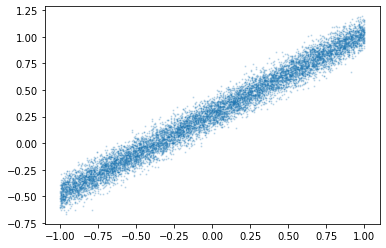

In [ ]:
# get 1-d data and visualize
X,Y = get_X_Y()
plt.scatter(X,Y,s=1, alpha=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


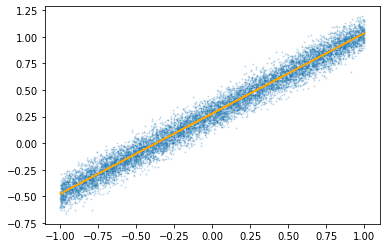

In [ ]:
# solving least squares with numpy
X_hom = np.concatenate([X,np.ones_like(X)],axis=-1)
(m,b), *_ = np.linalg.lstsq(X_hom, Y)
plt.scatter(X,Y, s=1, alpha=0.2)
plt.plot(X, m*X+b, c='orange')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


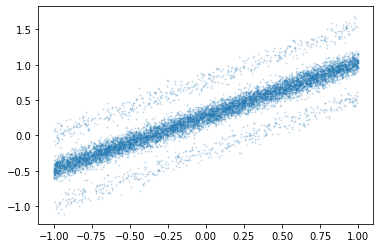

In [ ]:
# create a dataset with outliers
X,Y = get_X_Y(outlier=True)
plt.scatter(X,Y,s=1,alpha=0.2)

This new dataset contains some outliers. We want to fit a linear model without using the outliers. There exists a simple algorithm called "RANSAC" that can do exactly what we want. The pseudocode for 1-d data is shown below. Please implement the algorithm based on the pseudocode.

```
for n in range(num_round):
    Sample 2 datapoints from the dataset (2 pairs of (x,y)).
    Fit a linear model using the sampled data.
    Create predictions for the entire dataset using the fitted model.
    Compute an error between the predictions and the ground truths of the whole dataset
    Samples that have more error than a pre-defined threshold will be considered as outliers. The rest are considered as inliers.
    # (Inliers and outliers of each iteration are not to be combined. Each iteration produces a set of inliers and a set of outliers)

Use the biggest inliers set to fit the final linear model.
The smallest outliers set is considered the outliers of the dataset.

```
The error of a sample is computed by using absolute difference between the ground truth and the prediction from the model (i.e., |y - y_hat|)

In [ ]:
def ransac(X, Y, threshold=0.3, num_round=100):
    ############################################################################
    # TODO[1]: Implement the RANSAC algorithm.
    ############################################################################
    ans = {
        'inliers' : [],
        'outliers' : [],
    }
    for n in range(num_round):
      #Sample 2 datapoints from the dataset (2 pairs of (x,y)).
      idx1 = random.randint(0,len(X)-1)
      idx2 = random.randint(0,len(X)-1)
      y1, y2, x1, x2 = Y[idx1], Y[idx2], X[idx1], X[idx2]
      #Fit a linear model using the sampled data.
      A = np.concatenate([[x1,x2],np.ones_like([x1, x2])],axis=-1)
      m,b = np.linalg.lstsq(A, [y1,y2], rcond=None)[0]

      # Create predictions for the entire dataset using the fitted model.
      y_hat = m*X + b

      # Compute an error between the predictions and the ground truths of the whole dataset
      error = np.abs(Y-y_hat)
      
      # Samples that have more error than a pre-defined threshold will be considered as outliers. The rest are considered as inliers.
      outliers = np.argwhere(error.flatten() > threshold)
      inliers = np.argwhere(error.flatten() <= threshold)
      if len(inliers) > len(ans['inliers']):
        ans['inliers'] = inliers
        ans['outliers'] = outliers

    assert len(Y) == len(ans['inliers']) + len(ans['outliers'])
    #Use the biggest inliers set to fit the final linear model.
    A = np.concatenate([X[ans['inliers']].reshape((len(ans['inliers']), 1)),np.ones_like(X[ans['inliers']].reshape((len(ans['inliers']), 1)))],axis=-1)
    m,b = np.linalg.lstsq(A, Y[ans['inliers']].reshape((len(ans['inliers']), 1)), rcond=None)[0] 


    return m*X+b, ans['inliers'],ans['outliers']

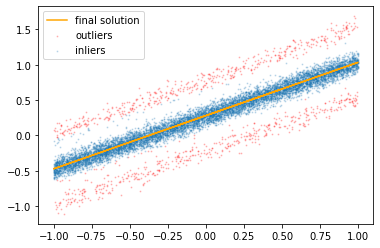

In [ ]:
# TODO[2]: Visualize the inliers, the outliers and the final model from the RANSAC algorithm.

final_model, inliers, outliers =  ransac(X,Y)
plt.plot(X, final_model, c='orange', label='final solution')
plt.scatter(X[outliers],Y[outliers],s=1,alpha=0.2, c = 'red', label='outliers') 
plt.scatter(X[inliers],Y[inliers],s=1,alpha=0.2, label='inliers')
plt.legend()

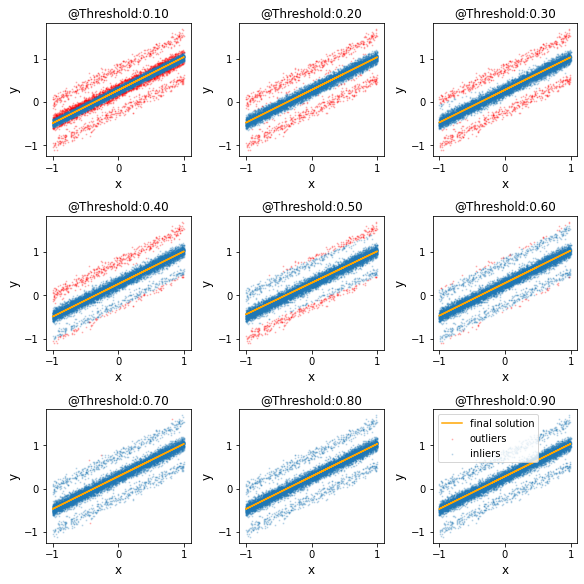

In [ ]:
#vary threshold 
fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(8,8))
t = 0.1
for ax in axs.flat:
  final_model, inliers, outliers =  ransac(X,Y,threshold = t)
  ax.plot(X, final_model, c='orange', label='final solution')
  ax.scatter(X[outliers],Y[outliers],s=1,alpha=0.2, c = 'red', label='outliers') 
  ax.scatter(X[inliers],Y[inliers],s=1,alpha=0.2, label='inliers')
  ax.set_xlabel('x', fontsize=12)
  ax.set_ylabel('y', fontsize=12)
  ax.set_title('@Threshold:{:.2f}'.format(t), fontsize=12)
  t+=0.1

plt.legend()

An example output of the visualization code

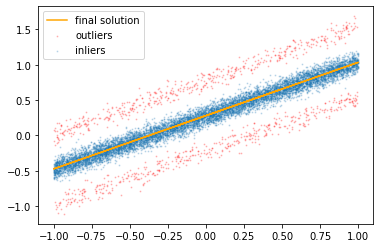


# WRITE-UP [1]
- What do you think is the limitation of this outlier detection method?

__Your answer:__ 

1. อัลกอริทึมนี้แปรผันตาม threshold ที่ตั้งเป็นเงื่อนไขในการพิจารณาว่าเป็น inliner หรือ outliner
2. ถ้าข้อมูลมีการกระจายสูงมากๆ(var สูง) อัลกอริทึมนี้จะไม่เวิร์ค
3. ข้อมูลที่ใช้(X, Y) ต้องมีความสัมพันธ์เชิงเส้น
___

# Part 2: Stochastic gradient descent
In machine learning, we usually deal with non-linear relationship of the data, high-dimensional data, and thousands of neural network weights, making linear least square infeasible. Instead of least squares, we resort to stochastic gradient descent (SGD) to iteratively update the weights of the neural network in the direction of steepest slope in the loss landscape. We start with an implementation of SGD for solving a linear relationship.

In [ ]:
def get_minibatch(*tensors,minibatch_size=1000):
    n = tensors[0].shape[0]
    for tensor in tensors:
        assert tensor.shape[0]==n
    idx = random.sample(range(n), k=n)
    n_minibatch = int(np.ceil(n/minibatch_size))
    for i in range(n_minibatch):
        bidx = idx[i*minibatch_size:(i+1)*minibatch_size]
        yield (t[bidx] for t in tensors)

def viz_over_time(losses):
    plt.plot(range(len(losses)), losses)
    plt.show()

def viz_prediction(X,Y,Y_hat):
    Y_hat = Y_hat.detach().numpy().squeeze()
    if X.shape[1]==1:
        plt.scatter(X,Y, s=0.1, alpha=0.1)
        plt.plot(X.numpy(), Y_hat, c='orange')
    elif X.shape[1]==2:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.plot(X[:,0].numpy(), X[:,1].numpy(), Y_hat,  c='orange')
        ax.scatter(X[:,0].numpy(), X[:,1].numpy(), Y.numpy(), s=1, alpha=0.1)
    plt.show()


In [ ]:
def predict(x, A, b):
    ##########################################################
    # TODO[3]: Return a prediction of the given inputs using the equation y = Ax + b
    # y: A tensor with the shape of [n_samples, 1]
    # x: The inputs of shape [n_samples, n_features]
    # A: A tensor with the shape of [n_features, 1]
    # b: A scalar tensor with shape (1,)
    # Hint: A single line of code is enough.
    ##########################################################
    return torch.nn.functional.linear(input = x, weight = A.T, bias=b)  #y 

def compute_loss(prediction, target):
    ##########################################################
    # TODO[4]: Return the mean square error (MSE) loss as a scalar.
    # Hint: A single line of code is enough.
    ##########################################################
    return torch.nn.functional.mse_loss(input = prediction, target = target)

def train(n_features):
    X,Y = get_X_Y(n_features=n_features, tensor=True)
    n_epochs = 20
    lr = 0.1
    losses = []
    
    A = torch.rand(n_features,1, requires_grad=True)
    b = torch.rand(1, requires_grad=True)
    
    for ep in range(n_epochs):
        for (inp,target) in get_minibatch(X,Y):
            ##########################################################
            # TODO[5]: Write an SGD training loop for learning a linear model (A and b).
            # According to the equation Y = AX + b, there are n_features parameters for A
            # and a single parameter for b (scalar).
            # Add the scalar loss of each training step to the `losses` list. It will be visualized by the code below.
            # The `predict` and `compute_loss` functions should be used here.
            # Use the `lr` variable as the learning rate for A and b.
            # Hint: Don't forget to remove the gradient of the previous training step.
            ##########################################################
            # YOUR CODE GOES HERE
            #optimizer = torch.optim.SGD(params = [A,b], lr=lr)
            #optimizer.zero_grad() #remove the gradient of the previous training step.
            y_predict = predict(inp,A,b) #forward propogation
            loss = compute_loss(y_predict,target) #compute MSE loss
            losses.append(loss.detach().numpy()) # Add the scalar loss of each training step to the `losses` list
            #back propogation
            loss.backward() 
            #optimizer.step()
            with torch.no_grad():
              for params in [A,b]: params -= params.grad*lr
            #optimizer.zero_grad() #remove the gradient of the previous training step.
            for params in [A,b]: params.grad = None
              
            ...
            ##########################################################
    viz_over_time(losses)
    Y_hat = predict(X,A,b)
    viz_prediction(X,Y,Y_hat)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


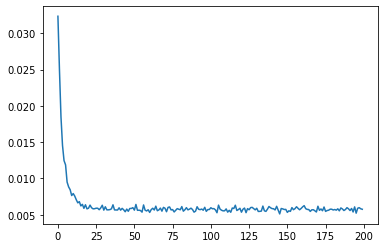

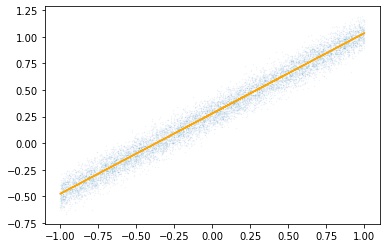

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


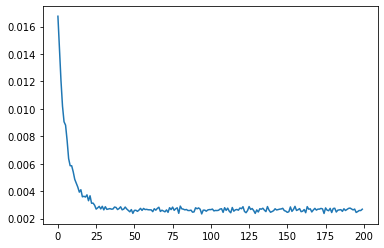

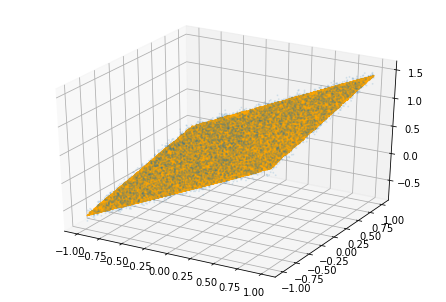

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


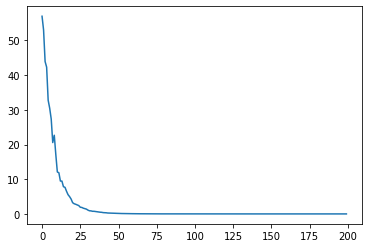

In [ ]:
# test with n_features equals to 1,2 and 1000
train(n_features=1)
train(n_features=2)
train(n_features=1000)

# Part 3: RNN for state prediction
In robotics, sometimes, we want to have a forward model that can predict the future states of the robot given the current and/or past states, i.e., p(x_{t+1}|x_t, x_{t-i}) where i>0.  This task is a regression task. In this part, we will implement a forward model with a recurrent neural network.

In [ ]:
def get_data():
    r = 1000
    x = torch.linspace(0,r,10001).unsqueeze(1)
    rad = (x - torch.floor(x/(2*np.pi)) * 2 * np.pi)
    sin = torch.sin(rad)
    cos = torch.cos(rad)
    data = torch.cat([rad / (2*np.pi), sin, cos],axis=-1)
    return data

In [ ]:
data = get_data()
print(f'Data shape: {data.shape}')

Data shape: torch.Size([10001, 3])


In [ ]:
# We can see that the data is a tensor of shape [n_samples, 3].
# Assume that the next state x_{t+1} is a function of the current state x_t and
# previous states x_{t-i} for i in {1,...,W} where W is the windows size,
# we can create a dataset for supervised training by using the data we have.
def create_dataset_for_rnn(seq, window_size=10):
    X = seq[:-1]
    X = X.reshape(X.shape[0]//window_size, window_size, X.shape[-1])
    Y = seq[1:]
    Y = Y.reshape(Y.shape[0]//window_size, window_size, Y.shape[-1])
    return X,Y

In [ ]:
# ref: https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook
#       
from torch.autograd import Variable
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.layer_dim = layer_dim
        # Number of output_dim
        self.output_dim = output_dim
        # Number of seq_length
        self.seq_length = seq_length
        # RNN
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        self.fc = torch.nn.Linear(hidden_dim, seq_length*output_dim)
    
    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out.view(-1, self.seq_length, self.output_dim )



In [ ]:
def create_model():
    ##########################################################
    # TODO[6]: Return an rnn model.
    ##########################################################
    input_dim = 3  #X.size(2)
    hidden_dim = 3
    layer_dim = 1   
    seq_length = 10  
    output_dim = 3 #Y.size(2)
    return RNNModel(input_dim, seq_length, hidden_dim, layer_dim, output_dim)

def train_rnn(data):
    X,Y = create_dataset_for_rnn(data)
    losses = []
    ##########################################################
    # TODO[7]: Write a training loop for your rnn model and return a trained model.
    # Again, add a scalar loss at each training step to the `losses` list.
    # `create_model` function should be used here.
    ##########################################################
    # YOUR CODE GOES HERE
    model = create_model()
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(params = model.parameters(), lr=0.01)
    for i in range(2000):
        total = 1 
        for (inp,target) in get_minibatch(X,Y, minibatch_size=25):
            total += 1
            inp, target = Variable(inp), Variable(target)
            optimizer.zero_grad()
            output = model(inp)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        losses.append(loss.cpu().detach().numpy()/total)
    ##########################################################
    viz_over_time(losses)
    return model
    

After obtaining the forward model, we can predict future states autoregressively. That is, given an initial chunk of states, the model can predict the next state and use the predicted next state as a part of the input.
For example, with the initial input is a tensor of shape [1,10,3], the model will output the next state as a tensor of shape [1,1,3], which can be used output the "next next" state with shape [1,1,3] so on and so forth. We ask you to implement this "imagination" feature of the model.

In [ ]:
def autoregressive_prediction(data, model, n_future_states=100):
    pred = []
    inp = data[:10].unsqueeze(0)
    ##########################################################
    # TODO[8]: Auto-regressively predict the future states for `n_future_states` steps.
    # `pred` is a list of tensors of shape [3,] (without batch and time dimension) which will be used in the visualization code.
    # The initial input is the first 10 timesteps of the data.
    ##########################################################
    # YOUR CODE GOES HERE
    model.eval()
    for n in range(n_future_states):
      inp  = model(inp)
      inp_numpy  = inp.detach().numpy()  
      pred.append(inp_numpy[:,-1,:].flatten())
    
    ##########################################################
    for i in range(1,3):
        viz_imagination(data,pred,i)

def viz_imagination(data, pred, feature):
    pred = np.array(pred)
    length = 50
    plt.plot(data[10:length+10,0], data[10:length+10,feature], label='gt')
    plt.plot(data[10:length+10,0], pred[:length,feature], label='pred')
    plt.plot(data[:10,0], data[:10,feature],label='inp')
    plt.legend()
    plt.show()


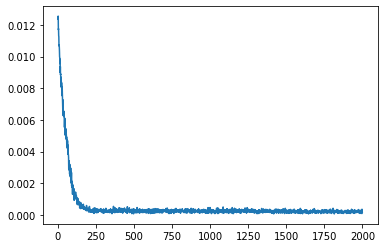

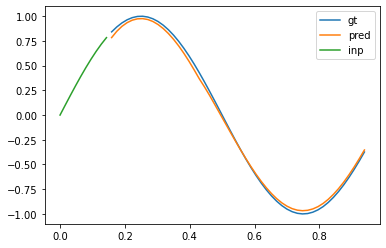

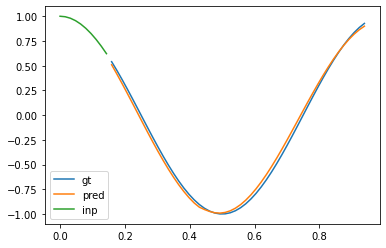

In [ ]:
model = train_rnn(data)
autoregressive_prediction(data, model)


# WRITE-UP [2]
- What is the problem when the model predicts further into the future? Why this problem occurs? What could be a potential remedy to this problem?

__Your answer:__

autoregressive เป็นการคาดการณ์ค่าถัดไปโดยใช้ค่าที่มีมาก่อนหน้า ดังนั้นจะมีปัญหาหาก Y หลังๆมีค่าผิดปกติจะทำให้คาดการณ์หลังจากนั้นผิดพลาดเพิ่มขึ้นเรื่อยๆได้(เหมือนโดมิโน่ล้ม)  ซึ่งเกิดจาก ในช่วงที่คาดการณ์อนุกรมเวลาไม่มีความคงที่ และไม่มีค่าเปรียบเทียบความผิดพลาดที่คิดจากข้อมูลที่ผ่านมา เพื่อหักลบกับค่าปัจจุบัน ดังนั้นในการแก้ปัญหานี้ วิธีแก้คือการเพิ่มของเทอมของ Integrated(d) และ Moving average process

ref: [link](https://lengyi.medium.com/arima-model-%E0%B8%95%E0%B8%AD%E0%B8%99%E0%B8%97%E0%B8%B5%E0%B9%88-1-%E0%B9%80%E0%B8%82%E0%B9%89%E0%B8%B2%E0%B9%83%E0%B8%88-arima-%E0%B9%81%E0%B8%9A%E0%B8%9A-practical-6d66a36f4e82), [link2](https://nutdnuy.medium.com/%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%9E%E0%B8%A2%E0%B8%B2%E0%B8%81%E0%B8%A3%E0%B8%93%E0%B9%8C%E0%B8%82%E0%B9%89%E0%B8%AD%E0%B8%A1%E0%B8%B9%E0%B8%A5%E0%B8%AD%E0%B8%99%E0%B8%B8%E0%B8%81%E0%B8%A3%E0%B8%A1%E0%B9%80%E0%B8%A7%E0%B8%A5%E0%B8%B2%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2%E0%B9%80%E0%B8%97%E0%B8%84%E0%B8%99%E0%B8%B4%E0%B8%84-arima-%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2-python-44809eb8e990)

___

# Part 4: convolutional neural network and beyond
In this section, we are going to build various models to train a predictive model. The problem is formulated as a binary classification problem. However, the dataset provide 2 features to predict the binary target. The first feature is a [n_samples, 1, 5, 5] tensor, you can think of it as a single-channel 5x5 images. The other feature is a [n_samples, 3] tensor.

In [ ]:
def get_non_linear_dataset():
    torch.manual_seed(1)
    n_samples = 100000
    threshold = 0.7
    n_features_x = 5
    n_features_y = 3
    feature1 = torch.rand(n_samples, 1 ,n_features_x, n_features_x)
    feature2 = torch.rand(n_samples, n_features_y)
    box_filter = torch.ones(1,1,3,3) * 1/9 # [out_channel, in_channel, h, w]
    conv = torch.nn.functional.conv2d(feature1,box_filter)
    val = conv.reshape(n_samples,9).max(-1).values # [n_months * n_days]
    label = torch.zeros(n_samples)
    label[feature2.mean(-1)>0.5] = torch.where(val[feature2.mean(-1)>0.5]>threshold,1.,0.)
    label[feature2.mean(-1)<=0.5] = torch.where(val[feature2.mean(-1)<=0.5]>0.7*threshold,1.,0.)

    return feature1, feature2, label

### We are going to explore different ways to build a predictive model
As a research engineer, you will be testing hypotheses from the researchers. In this task, the researchers require you to implement these 3 models
1. Feed-forward network: All features are flatten and concatenated.
2. Convolutional network: The first feature will be fed through a CNN and the other feature will be concatenated with a hidden features after the CNN.
3. Hypernetwork: The second feature will be used as an input of a "hypernetwork" that produces the weights of the CNN. The first feature will then be passed through the CNN.

## Feedforward model
A diagram showing the overview of a feedforward neural network. f1 and f2 are `feature1` and `feature2` respectively. The plus symbol within a circle represents the concatenate operation. FC is the fully connected layer. The model outputs the probability of the positive label.

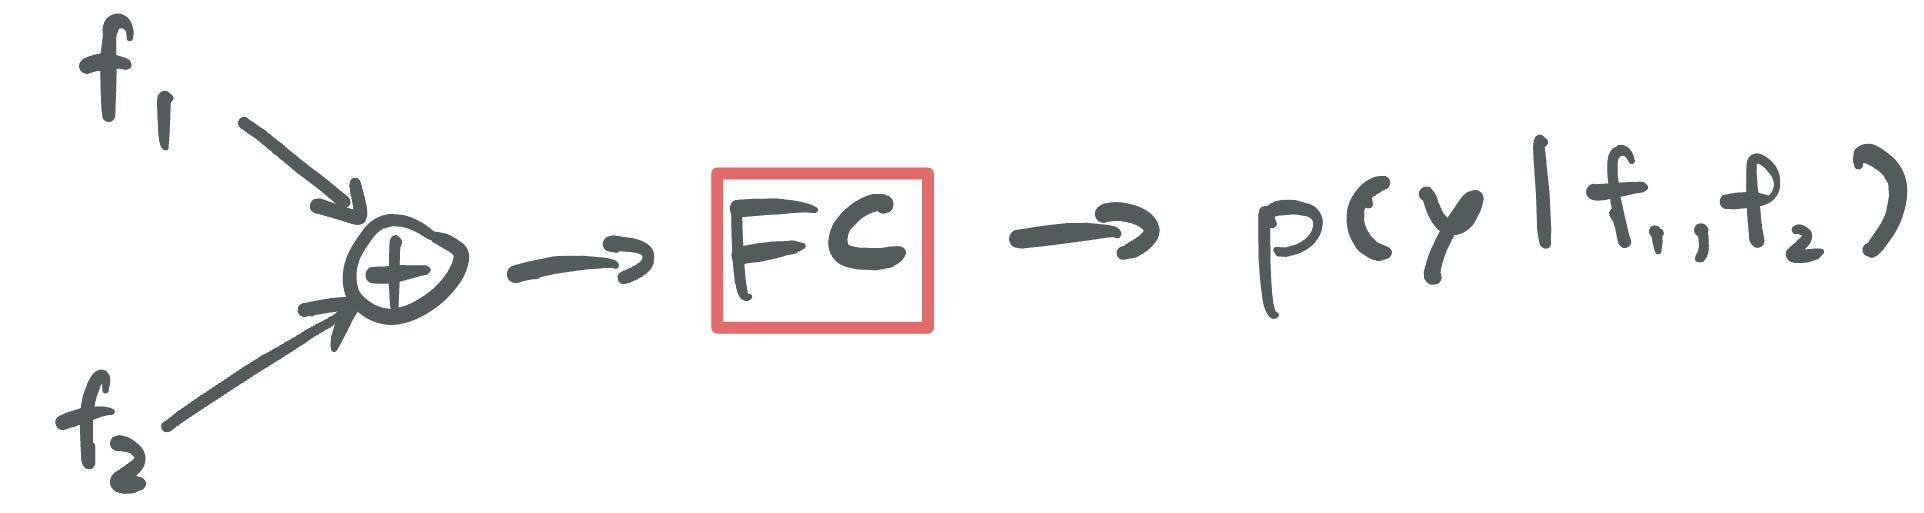

In [ ]:
#####################################################################################################
#helper function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi -L
#ref : https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
def initialize_weights(m):
  if isinstance(m, torch.nn.Conv2d):
      torch.nn.init.kaiming_uniform_(m.weight.data,nonlinearity='leaky_relu')
      if m.bias is not None:
          torch.nn.init.zeros_(m.bias.data)
  elif isinstance(m, torch.nn.Linear):
      torch.nn.init.kaiming_uniform_(m.weight)
      torch.nn.init.zeros_(m.bias.data)

#ref : https://github.com/ai-builders/curriculum/blob/main/notebooks/03_sgd_from_scratch.ipynb      
#if target == 1, loss is how far it is from 1
#if target == 0, loss is how far it is from 0
def loss_fn(predictions, targets): return torch.where(targets==1, 1-predictions, predictions).mean()

# ref : https://discuss.pytorch.org/t/calculate-accuracy-in-binary-classification/91758
def get_accuracy(y_prob, y_true):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5 #เพราะตรง output layer ผ่านฟังก์ชั่น sigmoid ดังนั้นให้ prop > 0.5 return 1, otherwise return 0
    return (y_true == y_prob).sum().item() / y_true.size(0)
#####################################################################################################


cpu
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:

def get_feedforward_model():
    ##########################################################
    # TODO[9]: Return a feedforward model that takes flatten feature1 concatenate with feature2 as the input.
    # Specifically, the input to the network will have the shape of [n_samples, 28].
    # The model should have 2 fully-connected hidden layers.
    # The last linear layer gives the probability of the positive label.
    ##########################################################
    net = torch.nn.Sequential( torch.nn.Linear(28,14),
                                torch.nn.LeakyReLU(0.1),
                                torch.nn.Dropout(p=0.2),
                              
                                torch.nn.Linear(14,7),
                                torch.nn.LeakyReLU(0.1),
                              
                                torch.nn.Linear(7,1),
                                torch.nn.Sigmoid())
    return net.apply(initialize_weights)

from sklearn.model_selection import train_test_split
import time

def train_feedforward_model():
    feature1,feature2,label = get_non_linear_dataset()
    losses = []
    acc_list = []
    ##########################################################
    # TODO[10]: Train a feedforward predictive model
    # Again, the losses and acc_list should contain the loss and training accuracy of each training step.
    ##########################################################
    # YOUR CODE GOES HERE
    n_epochs = 25
    lr = 0.001
    X = torch.cat((feature1.view((len(feature1),25)), feature2), 1)
    model = get_feedforward_model()
    model = model.to(device)
    optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
    start = time.time()

    for ep in range(n_epochs):
        train_loss, test_loss = 0.0, 0.0
        train_acc, test_acc = 0.0, 0.0
        total = 1 #n_samples/minibatch_size
        for (inp,target) in get_minibatch(X,label, minibatch_size=250):
            total += 1
            #train:80% test:20%
            train_idx, test_idx= train_test_split(np.arange(len(target)), 
                                                  test_size=0.2, 
                                                  stratify=target)

            inp,target = inp.to(device), target.to(device)
            inp_train, inp_test = inp[train_idx], inp[test_idx]
            target_train, target_test = target[train_idx], target[test_idx]

            optimizer.zero_grad() #remove the gradient of the previous training step.

            model.train()
            outputs = model(inp_train) #forward propogation
            loss = loss_fn( outputs.flatten(), target_train.flatten()) #compute loss
            
            #back propogation
            loss.backward() 
            optimizer.step()

            train_loss += loss.cpu().detach().numpy()
            train_acc += get_accuracy( outputs.flatten(), target_train.flatten())

            model.eval()
            with torch.no_grad():
              outputs = model(inp_test)
              loss = loss_fn( outputs.flatten(), target_test.flatten()) #compute loss
              test_loss += loss.cpu().detach().numpy()
              test_acc += get_accuracy( outputs.flatten(), target_test.flatten())

        losses.append([train_loss/total, test_loss/total])
        acc_list.append([train_acc/total, test_acc/total])

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('min loss-> train: {:.4f} test: {:.4f}'.format(np.min(losses,0)[0], np.min(losses,0)[1]))
    print('mean acc-> train: {:.4f} test: {:.4f}'.format(np.average(acc_list,0)[0], np.average(acc_list,0)[1]))
    print('train phase: blue ,  test phase: orange')
    ##########################################################
    viz_over_time(losses)
    viz_over_time(acc_list)


In [ ]:
model = get_feedforward_model()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total_params: ',pytorch_total_params)

total_params:  519


Training complete in 0m 29s
min loss-> train: 0.1046 test: 0.1008
mean acc-> train: 0.8729 test: 0.8805
train phase: blue ,  test phase: orange


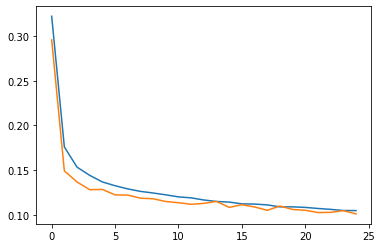

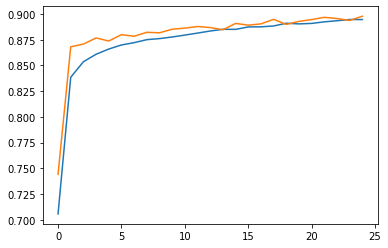

In [ ]:
train_feedforward_model()

## Convolutional model
To incorporate a CNN, we first pass f1 through the CNN and a fully-connected hidden layer. The second feature is then concatenated with the output of the hidden layer before passing through the rest of the network.

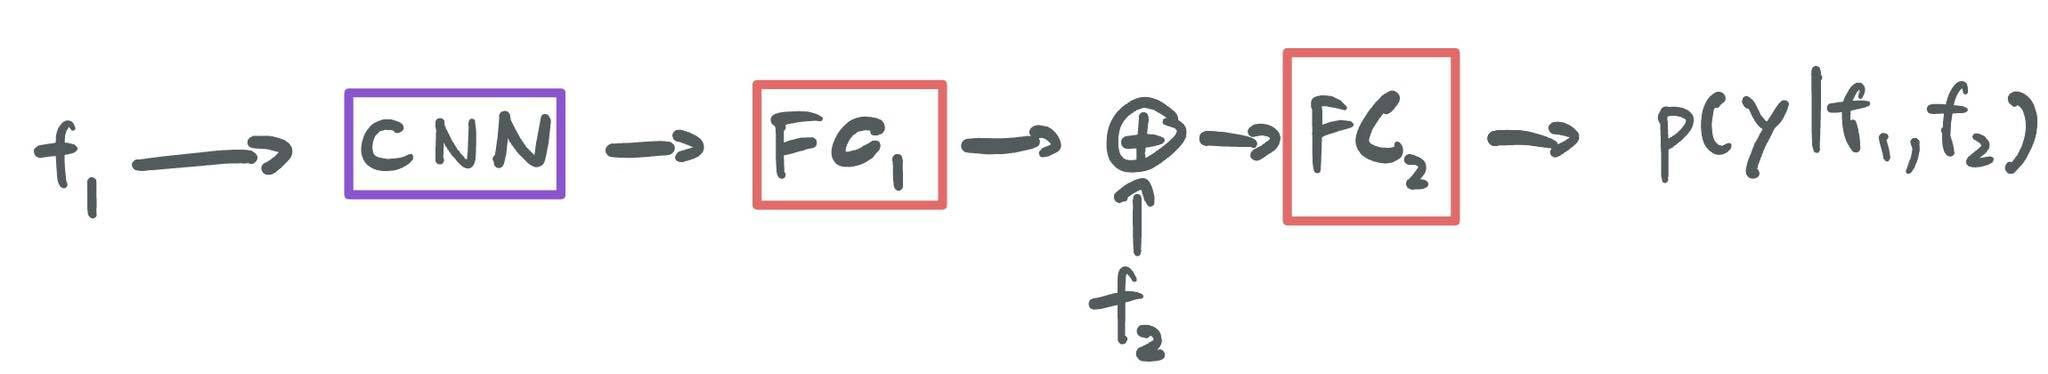

In [ ]:

def create_cnn_model():
    ##########################################################
    # TODO[11]: Return a cnn model.
    # The model should have 1 layer of CNN followed by 2 fully-connected hidden layers.
    # The second feature (feature2) should be concatenated with the output of the first fully-connected hidden layer.
    # The last linear layer gives the probability of the positive label.
    ##########################################################
    net = cnn_model()
    return net.apply(initialize_weights)

#ref: https://stackoverflow.com/questions/51700729/how-to-construct-a-network-with-two-inputs-in-pytorch
class cnn_model(torch.nn.Module):
  def __init__(self):
    super(cnn_model, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=2, stride=1, padding=1,)
    self.conv2 = torch.nn.Conv2d(6, 10, kernel_size=2,)
    self.pool = torch.nn.MaxPool2d(2, 2)
    self.fc1 = torch.nn.Sequential( torch.nn.Linear(10,15),
                                torch.nn.LeakyReLU(0.1),
                                torch.nn.Dropout(p=0.2),
                                torch.nn.Linear(15,8),
                                torch.nn.LeakyReLU(0.1),
                                torch.nn.Linear(8,3),
                                torch.nn.LeakyReLU(0.1),)
    
    self.fc2 = torch.nn.Sequential( torch.nn.Linear(6,12),
                                torch.nn.LeakyReLU(0.1),
                                torch.nn.Linear(12,5),
                                torch.nn.Dropout(p=0.2),
                                torch.nn.LeakyReLU(0.1),
                                torch.nn.Linear(5,1),
                                torch.nn.Sigmoid())

  def forward(self, input1, input2):
    cnn1_out = self.pool(torch.nn.functional.relu(self.conv1(input1)))
    cnn2_out = self.pool(torch.nn.functional.relu(self.conv2(cnn1_out)))
    fc1_in = torch.flatten(cnn2_out, 1)
    fc1_out = self.fc1(fc1_in)
    combined = torch.cat((fc1_out,input2), 1)
    out = self.fc2(combined)
    return out
#โมเดลนี้ต้องการให้อินพุต1 กับอินพุต2 ทำงานไม่พร้อมกัน เลยเขียนแบบคลาสน่าจะเวิร์คกว่า

def train_cnn_model():
    # Train a convolution network
    feature1,feature2,label = get_non_linear_dataset()
    losses = []
    acc_list = []
    ##########################################################
    # TODO[12]: Train a CNN predictive model
    # Again, the losses and acc_list should contain the loss and training accuracy of each training step.
    ##########################################################
    # YOUR CODE GOES HERE
    n_epochs = 25
    lr = 0.001
    model = create_cnn_model()
    model = model.to(device)
    optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
    start = time.time()

    for ep in range(n_epochs):
        train_loss, test_loss = 0.0, 0.0
        train_acc, test_acc = 0.0, 0.0
        total = 1 #n_samples/minibatch_size
        for (inp1,inp2,target) in get_minibatch(feature1,feature2,label, minibatch_size=250):
            total += 1
            train_idx, test_idx= train_test_split(np.arange(len(target)), 
                                                  test_size=0.2, 
                                                  stratify=target)
            
            inp1,inp2,target = inp1.to(device),inp2.to(device),target.to(device)
            inp1_train, inp1_test = inp1[train_idx], inp1[test_idx]
            inp2_train, inp2_test = inp2[train_idx], inp2[test_idx]
            target_train, target_test = target[train_idx], target[test_idx]

            optimizer.zero_grad() #remove the gradient of the previous training step.

            model.train()
            outputs = model(inp1_train, inp2_train) #forward propogation
            loss = loss_fn( outputs.flatten(), target_train.flatten()) #compute loss
            #back propogation
            loss.backward() 
            optimizer.step()

            train_loss += loss.cpu().detach().numpy()
            train_acc += get_accuracy( outputs.flatten(), target_train.flatten())

            model.eval()
            with torch.no_grad():
              outputs = model(inp1_test, inp2_test)
              loss = loss_fn( outputs.flatten(), target_test.flatten()) #compute loss
              test_loss += loss.cpu().detach().numpy()
              test_acc += get_accuracy( outputs.flatten(), target_test.flatten())

        losses.append([train_loss/total, test_loss/total])
        acc_list.append([train_acc/total, test_acc/total])

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('min loss-> train: {:.4f} test: {:.4f}'.format(np.min(losses,0)[0], np.min(losses,0)[1]))
    print('mean acc-> train: {:.4f} test: {:.4f}'.format(np.average(acc_list,0)[0], np.average(acc_list,0)[1]))
    print('train phase: blue ,  test phase: orange')
    ##########################################################
    viz_over_time(losses)
    viz_over_time(acc_list)


In [ ]:
model = create_cnn_model()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total_params: ',pytorch_total_params)

total_params:  755


Training complete in 1m 22s
min loss-> train: 0.0879 test: 0.0837
mean acc-> train: 0.8953 test: 0.9035
train phase: blue ,  test phase: orange


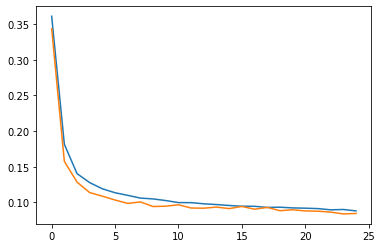

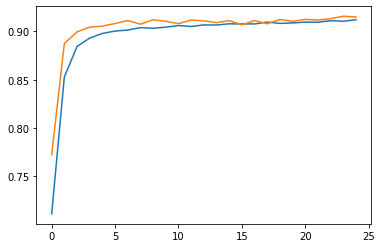

In [ ]:
train_cnn_model()

## Hypernetwork
A diagram illustrating the structure of a hypernetwork. HN an a hypernetwork, which can be implemented as a fully-connected layers that output the weights W.
W is reshaped and used as a kernel which will be convolved (the pruple star) with f1. This means that each sample will have different kernel weights. After the convolution, the feature is flatten and fed to the fully-connected layers (FC). The last linear layer output the probability of the positive class, p(y|f1,f2). In your implementation, please make sure the the weights of the hypernetwork is differentiable through all theses operations.

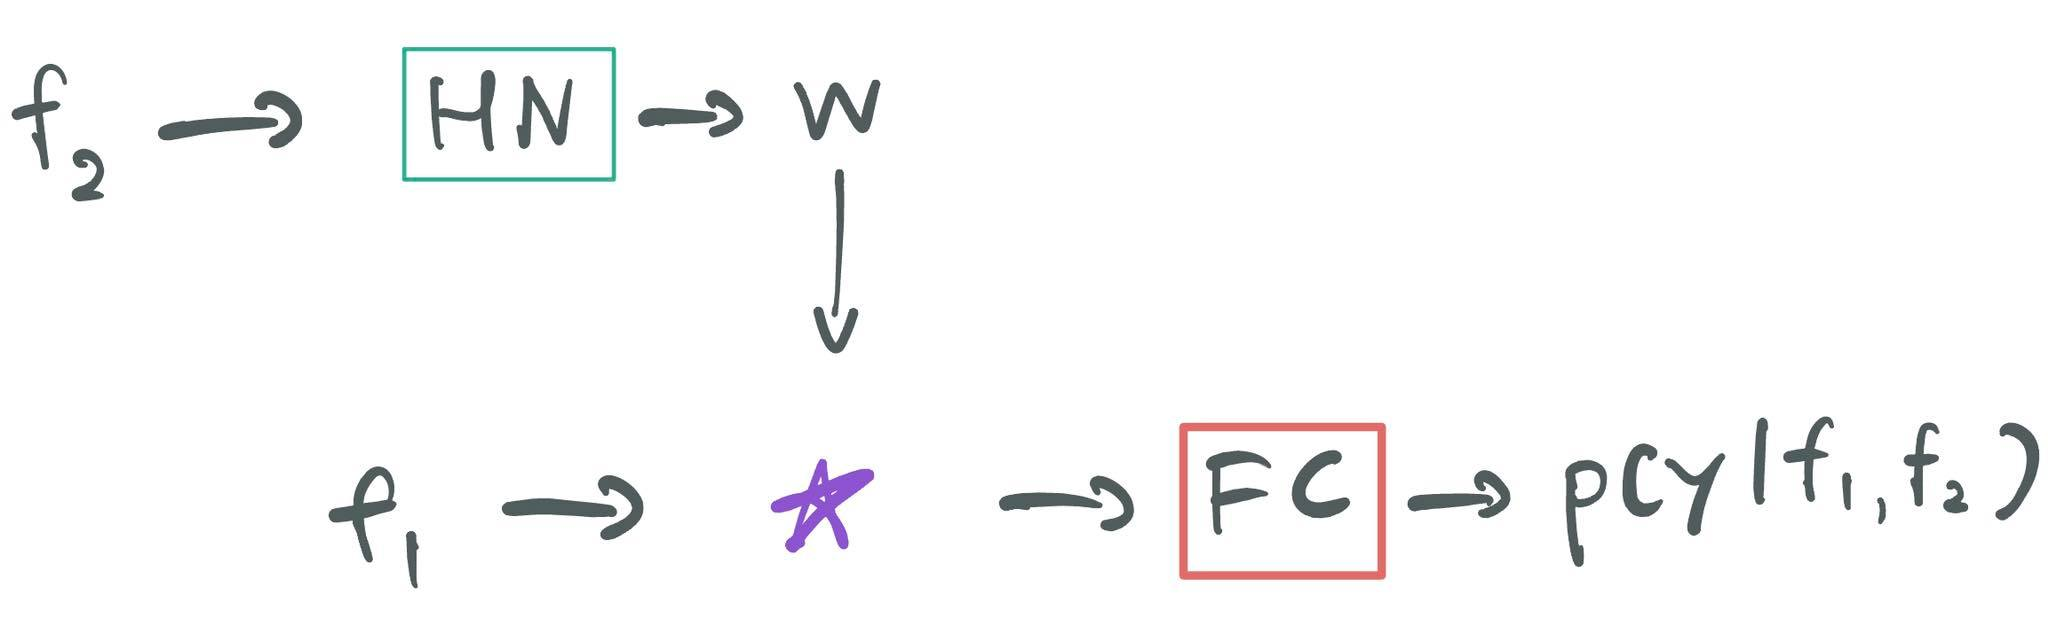

In [ ]:
def create_hyper_model():
    ##########################################################
    # TODO[13]: Return a hypernetwork model
    # The hypernetwork uses the second feature (feature2) to output kernel weights.
    # The first feature (feature1) will be convolved with the kernel output by the hypernetwork.
    # After convolution, the features are flatten and fed to the fully-connected hidden layers.
    # Hint: You might find this link helpful for doing convolution with different weights:
    # https://discuss.pytorch.org/t/how-to-apply-different-kernels-to-each-example-in-a-batch-when-using-convolution/84848
    ##########################################################
    net = hyper_model()
    return net.apply(initialize_weights)

class hyper_model(torch.nn.Module):
  def __init__(self):
    super(hyper_model, self).__init__()
    self.hypernetwork = torch.nn.Sequential(torch.nn.Linear(3,5),
                                            torch.nn.LeakyReLU(0.1),
                                            torch.nn.Linear(5,7),
                                            torch.nn.LeakyReLU(0.1),
                                            torch.nn.Linear(7,4),)
    
    self.fullyconnected = torch.nn.Sequential(torch.nn.Linear(36,18),
                                              torch.nn.LeakyReLU(0.1),
                                              torch.nn.Dropout(p=0.3),
                                              torch.nn.Linear(18,9),
                                              torch.nn.LeakyReLU(0.1),
                                              torch.nn.Linear(9,1),)

  def forward(self, input1, input2):
    N = input1.size(0)
    weights = []
    for idx in range(N):
      weight = self.hypernetwork(input2[idx:idx+1])
      weights.append(weight)

    weights = torch.stack(weights)
    weights = weights.view(-1, 1, 2, 2)
    # move batch dim into channels
    input1 = input1.view(1, -1, 5, 5)
    conv_out = torch.nn.functional.conv2d(input1, weights, stride=1, padding=1, groups=N)
    conv_out = conv_out.view(conv_out.size(1), conv_out.size(0), conv_out.size(2), conv_out.size(3))
    fc_in = torch.flatten(conv_out, 1)
  
    return torch.sigmoid(self.fullyconnected(fc_in))

def train_hypernetwork_model():
    # Train a hyper convolution network
    x,y,z = get_non_linear_dataset()
    losses = []
    acc_list = []
    ##########################################################
    # TODO[14]: Train a hypernetwork predictive model
    # Again, the losses and acc_list should contain the loss and training accuracy of each training step.
    ##########################################################
    # YOUR CODE GOES HERE
    n_epochs = 25
    lr = 0.001
    model = create_hyper_model()  
    model = model.to(device)
    optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
    start = time.time()

    for ep in range(n_epochs):
        train_loss, test_loss = 0.0, 0.0
        train_acc, test_acc = 0.0, 0.0
        total = 1 #n_samples/minibatch_size
        for (inp1,inp2,target) in get_minibatch(x,y,z,minibatch_size=250):
            total += 1
            train_idx, test_idx= train_test_split(np.arange(len(target)), 
                                                  test_size=0.2, 
                                                  stratify=target)
            
            inp1,inp2,target = inp1.to(device),inp2.to(device),target.to(device)
            inp1_train, inp1_test = inp1[train_idx], inp1[test_idx]
            inp2_train, inp2_test = inp2[train_idx], inp2[test_idx]
            target_train, target_test = target[train_idx], target[test_idx]

            optimizer.zero_grad() #remove the gradient of the previous training step.

            model.train()
            outputs = model(inp1_train, inp2_train) #forward propogation
            loss = loss_fn( outputs.flatten(), target_train.flatten()) #compute loss
            #back propogation
            loss.backward() 
            optimizer.step()

            train_loss += loss.cpu().detach().numpy()
            train_acc += get_accuracy( outputs.flatten(), target_train.flatten())

            model.eval()
            with torch.no_grad():
              outputs = model(inp1_test, inp2_test)
              loss = loss_fn( outputs.flatten(), target_test.flatten()) #compute loss
              test_loss += loss.cpu().detach().numpy()
              test_acc += get_accuracy( outputs.flatten(), target_test.flatten())
            
        losses.append([train_loss/total, test_loss/total])
        acc_list.append([train_acc/total, test_acc/total])

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('min loss-> train: {:.4f} test: {:.4f}'.format(np.min(losses,0)[0], np.min(losses,0)[1]))
    print('mean acc-> train: {:.4f} test: {:.4f}'.format(np.average(acc_list,0)[0], np.average(acc_list,0)[1]))
    print('train phase: blue ,  test phase: orange')
    ##########################################################
    viz_over_time(losses)
    viz_over_time(acc_list)

In [ ]:
model = create_hyper_model() 
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total_params: ',pytorch_total_params)

total_params:  941


Training complete in 7m 7s
min loss-> train: 0.0897 test: 0.0898
mean acc-> train: 0.8956 test: 0.8962
train phase: blue ,  test phase: orange


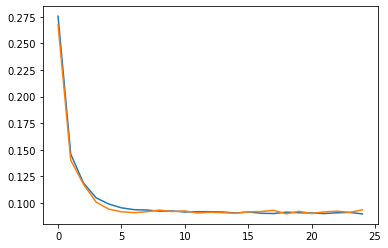

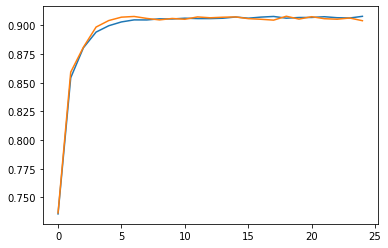

In [ ]:
train_hypernetwork_model()

# WRITE-UP [3]
- What are the pros and cons of each model?

__Your answer:__

_summary results_

_| Feedforward model  | Convolutionnal model | Hypernetwork 
--| -------------------|--------------------- | ------------
**train** |  |  | 
min losses | 0.1046  | 0.0879 | 0.0897
mean accuracy | 0.8729  | 0.8953 |0.8956
**test** |  |  | 
min losses | 0.1008  | 0.0837 | 0.0898
mean accuracy | 0.8805  | 0.9035 |0.8962
time| 0m 29s|1m 22s | 7m 7s

---
**Feedforward model**

pros: โมเดลมีขนาดเล็ก และใช้เวลาเทรนน้อย

cons: feature1 ที่ถูกนำมา concatenate ยังไม่ผ่านการสกัดฟีเจอร์ เราแค่ทำการกางภาพ(featur1) แล้วนำไปวางซ้อนกับ feature2 เพราะ fc ทำหน้าที่แค่ classify อย่างเดียว

---

**Convolutionnal model**

pros: feature1 ผ่านการสกัดฟีเจอร์ก่อนนำมา concatenateกับ feature2 ฉนั้นฟีเจอร์ที่ผ่านการสกัดจะแทนที่การเรียนรู้ภาพหนึ่งภาพเลย จะทำให้ส่วนของ classify ทำงานง่ายขึ้น

cons: Convolutionnal model ต้องการข้ามลึกของเลเยอร์โดยอิงจากขนาดของรูปภาพ เพราะยิ่งภาพใหญ่ก็จำเป็นต้องที่จะสกัดรายละเอียด/องค์ประกอบที่มีอยู่บนภาพเยอะขึ้นด้วย 

---

**Hypernetwork**

pros:Feature1 กับ Feature2 คอนโวลูตกันก่อนที่จะทำการ classify ดังนั้น distribution ของFeature จะถูกรวมกันด้วย จะไม่เกิด distribution ของแต่ละฟีเจอร์ที่ฉีกหรือแตกต่างจากกันมากนัก ดังนั้นในส่วนของ classify จะทำงานง่ายขึ้น

cons: ใช้เวลาเทรนนาน เพราะต้องทำการ คอนโวลูตแต่ละ sample ลองปรับไปใช้ gpu ก็ยังใช้เวลาพอสมควร

---